# Augmenting 5G data and reattempting classification task - adding a positive control task to make sure my data is being indexed correctly by the pytorch model
Split into down, no change, and up reg in copper condition

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7)
import seaborn as sns
import tqdm

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from Bio.Seq import reverse_complement

# import EarlyStopping
from pytorchtools import EarlyStopping


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [3]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


## Add pos control column

In [4]:
m1 = "TAT"
m2 = "GCG"

def set_pos_con_motif(seq):
    
    test_seq = seq.strip("N")[:6]
    if (m1 in test_seq and m2 in test_seq):
        print("both motifs in seq - skipping")
        c = 'skip'
    elif m1 in test_seq:
        c = 2
    elif m2 in test_seq:
        c = 0
    else:
        c = 1

    return c

In [5]:
XYdf_og['posc'] = XYdf_og['upstream_region'].apply(lambda x: set_pos_con_motif(x))
XYdf_og['posc_seq'] = XYdf_og['upstream_region'].apply(lambda x: x.strip("N")[:6])

In [6]:
XYdf_og[['posc']].value_counts()

posc
1       1930
2        139
0        135
dtype: int64

In [7]:
flank_data_filename = "data/XY_lr_noCu_opFilt_-400:100.tsv"
XYdf_flank = pd.read_csv(flank_data_filename,sep='\t')
XYdf_flank

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,AAAAATCGCAGGCAATCCATTACCCGACCACGGCAAATTGCTATGT...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,GTCAAATGAATCAGTTATTGCCTCGACATGCTTTTTTTACTGTGAA...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,CGGAACAGCTCTGGGAAACCACGCTCGACGCCAACAGCCGCCGCAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GTCTTTGGCCGAGCAGGTGACCGGCCGTCAACGCAAAATCCGTTTT...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GATGTTTACCGATTTAGAAGAAATATCGATTCAATGTCCTTACTGC...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,CGAGGAAGCTAAAACCAAACTCGAATCGATGATCCGTGAATACGTT...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACCCCAAGCAAAAAAGGGGTAAAGGAGGGGTAAAAATTGAAAGTTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GCCGAGGATCTAAGACAAGCGCAACATTGTCTCGGTGAAATTACCG...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [45]:
#loc2seq = dict([(x,z) for (x,z) in XYdf_og[['locus_tag','upstream_region']].values])
loc2seq = dict([(x,z) for (x,z) in XYdf_og[['locus_tag','posc_seq']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

loc2flankseq = dict([(x,z) for (x,z) in XYdf_flank[['locus_tag','upstream_region']].values])
print()
print(loc2flankseq['EQU24_RS19315'])
print()
print(loc2flankseq['EQU24_RS19315'].index(loc2seq['EQU24_RS19315']))

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGG

GATGTGGCTTGGCCGTTTTTAGCTTGACGCGCATGGCTTACGAACTCCGTCCTGCTAGGGAGATGCTGAATCTTTGGGCTTTAGCTGAAGAAACTTGCTAATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGAAATGGCTGCTACAACTGAGTCAGTTAAAGCTGATGCTGCAGAAGCACCACTTTTGAACAAAAAAAATATAATTGCCGGTGCATCTTTGTACCTGGTATTT

100


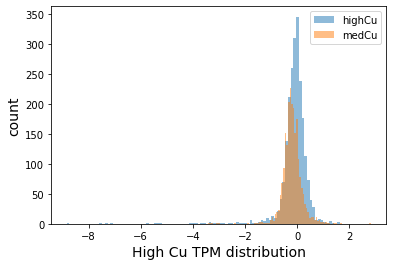

In [9]:
plt.hist(XYdf_og['highCu'].values,bins=100,label="highCu",alpha=0.5)
plt.hist(XYdf_og['medCu'].values,bins=100,label="medCu",alpha=0.5)

plt.legend()
plt.xlabel("High Cu TPM distribution",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### How many genes never change?

In [10]:
with open("data/conditions_to_include.txt",'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum']

In [11]:
data_filename = "data/XY_TPM_opFilt.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,52.045884,35.736190,30.829331,23.333155,44.348687,44.920897,47.861477,42.973556,64.784508,32.050358,35.462185,33.444023
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,59.991257,43.159066,33.532522,18.915775,59.629360,65.011074,79.109490,61.209155,99.002970,43.656760,41.792237,43.689839
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,33.943076,27.325800,18.491160,18.453916,28.268717,29.419165,33.534043,28.828713,44.856281,21.351623,20.644554,23.172675
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,48.648085,33.463183,31.643505,16.960643,49.839406,48.729958,48.662214,50.966799,77.842263,41.684925,34.258335,42.367072
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,27.213395,27.232565,12.892833,10.720823,27.164218,25.769601,29.013530,25.968531,19.520794,23.027211,32.713854,34.374071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,8591.278232,9584.028559,7477.339715,1298.257682,8345.785345,5934.168113,8132.547467,7157.344557,3468.582202,6497.868109,3942.957792,5085.637409
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,43.551349,26.951394,18.356915,15.624619,43.065124,43.954096,48.894308,43.386082,40.548782,26.273485,15.972203,16.423284
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,46.058548,31.889009,20.231568,26.004364,44.419579,34.993692,46.109300,36.872718,37.139500,23.525245,49.216725,44.623117
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,31.182164,23.882390,19.721043,20.960234,34.601933,32.907138,30.125207,31.899782,38.204218,26.432667,40.000662,43.201743


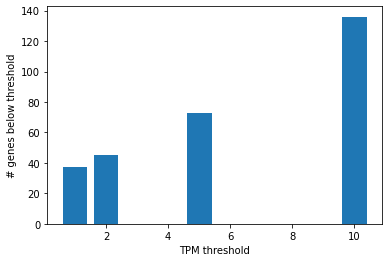

In [12]:
no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []
for i, row, in tpm_df.iterrows():
    tpms = row[conds].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [13]:
len(no_tx_genes2)

45

In [14]:
# do any of these show up in the log ratio up/down?
XYdf_og[XYdf_og['locus_tag'].isin(no_tx_genes2)].sort_values('highCu')[['locus_tag','highCu']]

,locus_tag,highCu
1165,EQU24_RS11910,-1.958143
118,EQU24_RS01215,-0.923850
17,EQU24_RS00205,-0.624566
1943,EQU24_RS19655,-0.624566
783,EQU24_RS07995,-0.170096
1178,EQU24_RS12090,0.000000
1243,EQU24_RS12810,0.000000
1584,EQU24_RS16040,0.000000
1669,EQU24_RS16985,0.000000
1745,EQU24_RS17885,0.000000


In [15]:
# filter out genes that never express above 2 tpms in any condition tested
XYdf = XYdf_og[~XYdf_og['locus_tag'].isin(no_tx_genes2)].reset_index().drop('index',axis=1)
XYdf['product'] = XYdf['locus_tag'].apply(lambda x: locus2info[x]['product'])

## Add regulatory class to XYdf

In [16]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))
    
def set_reg_class_yes_no(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 0
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 0
        else:
            return 1
    
    reg_col = f"{col}_reg_YN"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [17]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
set_reg_class_yes_no(XYdf,'highCu',thresh=0.6)
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,posc,posc_seq,product,highCu_reg_UD,highCu_reg_YN
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,1,ACTGTT,chromosomal replication initiator protein DnaA,1,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,1,GTGGAC,DNA polymerase III subunit beta,1,1
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,0,TTGCGA,DNA replication/repair protein RecF,1,1
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,1,GATGGG,hypothetical protein,1,1
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,1,GAATTT,bifunctional diguanylate cyclase/phosphodieste...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,1,GAAGAC,hypothetical protein,1,1
2155,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,0,AGCGCA,type II toxin-antitoxin system HicA family toxin,1,1
2156,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,1,ACTGGT,DUF4102 domain-containing protein,1,1
2157,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,1,GAAAAT,NaN,1,1


In [18]:
XYdf['highCu_reg_UD'].value_counts()

1    1956
0     145
2      58
Name: highCu_reg_UD, dtype: int64

In [19]:
XYdf['highCu_reg_YN'].value_counts()

1    1956
0     203
Name: highCu_reg_YN, dtype: int64

In [20]:
# see CuUp class df
XYdf[XYdf['highCu_reg_UD']==2].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN','posc']]

,locus_tag,product,highCu,highCu_reg_UD,highCu_reg_YN,posc
2003,EQU24_RS20690,DEAD/DEAH box helicase,0.601137,2,0,1
440,EQU24_RS04625,aminotransferase class V-fold PLP-dependent en...,0.605933,2,0,1
1177,EQU24_RS12320,NADPH-dependent 7-cyano-7-deazaguanine reducta...,0.608029,2,0,1
1570,EQU24_RS16200,EAL domain-containing protein,0.608627,2,0,1
1035,EQU24_RS10820,efflux RND transporter periplasmic adaptor sub...,0.610098,2,0,1
2027,EQU24_RS20860,ribonucleotide reductase,0.613476,2,0,1
808,EQU24_RS08410,response regulator,0.615717,2,0,1
1573,EQU24_RS16225,circularly permuted type 2 ATP-grasp protein,0.616791,2,0,1
1139,EQU24_RS11890,hypothetical protein,0.629000,2,0,1
962,EQU24_RS09990,30S ribosomal protein S6,0.632446,2,0,1


In [21]:
# see cudown class df
XYdf[XYdf['highCu_reg_UD']==0].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN','posc']]

,locus_tag,product,highCu,highCu_reg_UD,highCu_reg_YN,posc
576,EQU24_RS05885,methane monooxygenase,-8.844506,0,0,1
577,EQU24_RS05905,soluble methane monooxygenase-binding protein ...,-7.574592,0,0,1
579,EQU24_RS05920,hypothetical protein,-7.357154,0,0,1
578,EQU24_RS05915,BLUF domain-containing protein,-7.275122,0,0,1
580,EQU24_RS05925,likely chaperone for smmo,-7.104795,0,0,1
...,...,...,...,...,...,...
1492,EQU24_RS15440,hypothetical protein,-0.606958,0,0,1
11,EQU24_RS00165,hypothetical protein,-0.604148,0,0,0
1081,EQU24_RS11350,hypothetical protein,-0.603603,0,0,1
519,EQU24_RS05405,ShlB/FhaC/HecB family hemolysin secretion/acti...,-0.603308,0,0,1


In [22]:
XYdf[XYdf['locus_tag']=='EQU24_RS19315']

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,posc,posc_seq,product,highCu_reg_UD,highCu_reg_YN
1867,3671,EQU24_RS19315,ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAAT...,0.954381,1.313821,1.459975,-0.526926,0.0,0.600282,0.909567,0.389121,0.351281,1.326338,1.172579,1.305701,1,ATCAGG,methane monooxygenase/ammonia monooxygenase su...,2,0


### Train/val/test splitting

In [23]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x=score_col, y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl,classes=[0,1,2]):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in classes:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                print(f"WARNING: no instance of class {cls} in batch {i}")
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


In [24]:
# specs for class partition dict
cpd = {
    0: {'train_test':0.8, 'train_val':0.8},
    1: {'train_test':0.8, 'train_val':0.8},
    #2: {'train_test':0.75, 'train_val':0.66},
    2: {'train_test':0.8, 'train_val':0.8},
}

In [25]:
def stratified_partition(df, class_partition_dict,class_col='reg'):
    '''
    Given a specification for how to split specific classes into 
    train-test and train-val, implement those splits independently 
    and return final dfs for train/test/val splits
    '''
    
    # make sure classes and CPD specs match
    assert set(class_partition_dict.keys()) == set(df[class_col].unique())
    
    final_full_train = pd.DataFrame(columns=df.columns)
    final_test = pd.DataFrame(columns=df.columns)
    final_train = pd.DataFrame(columns=df.columns)
    final_val = pd.DataFrame(columns=df.columns)

    
    for c in cpd:
        temp_df = df[df[class_col]==c]
        print(f"class {c}: {temp_df.shape[0]} examples")
        full_train,test = tu.quick_split(temp_df, split_frac=cpd[c]['train_test'])
        train,val = tu.quick_split(full_train, split_frac=cpd[c]['train_val'])
        
        final_full_train = pd.concat([final_full_train, full_train])
        final_test = pd.concat([final_test, test])
        final_train = pd.concat([final_train, train])
        final_val = pd.concat([final_val, val])
        
    return final_full_train, final_test, final_train, final_val
        

In [27]:
full_train_df, \
test_df, \
train_df, \
val_df = stratified_partition(XYdf, cpd, class_col='posc')
#val_df = stratified_partition(XYdf, cpd, class_col='highCu_reg_UD')


class 0: 133 examples
class 1: 1893 examples
class 2: 133 examples


In [28]:
class_col = 'posc' # 'highCu_reg_UD'
print("Full Train")
display(full_train_df[class_col].value_counts())
print("Test")
display(test_df[class_col].value_counts())
print("Train")
display(train_df[class_col].value_counts())
print("Val")
display(val_df[class_col].value_counts())

Full Train


1    1514
0     106
2     106
Name: posc, dtype: int64

Test


1    379
0     27
2     27
Name: posc, dtype: int64

Train


1    1211
0      84
2      84
Name: posc, dtype: int64

Val


1    303
0     22
2     22
Name: posc, dtype: int64

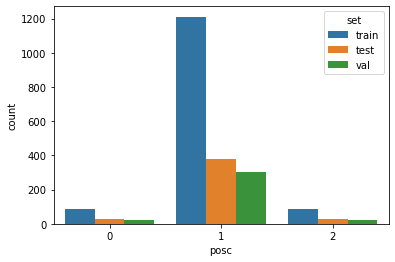

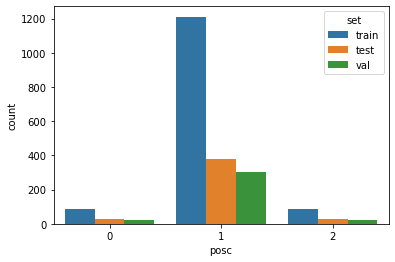

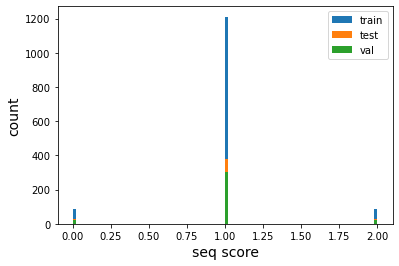

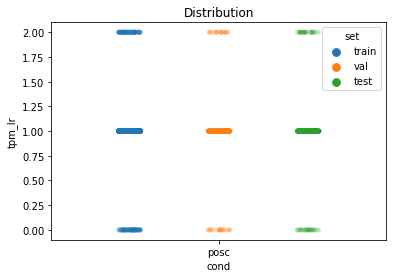

In [29]:
# plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_YN')
# plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_UD')
# plot_train_test_hist(train_df, test_df,val_df=val_df,score_col='highCu',bins=100)
# view_train_test_dist(train_df, test_df,["highCu"],val_df=val_df,id_col='locus_tag')

plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col=class_col)
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col=class_col)
plot_train_test_hist(train_df, test_df,val_df=val_df,score_col=class_col,bins=100)
view_train_test_dist(train_df, test_df,[class_col],val_df=val_df,id_col='locus_tag')


## Data augmentation strategies
1. reverse complement + sliding window
2. mutation rate

In [26]:
# def augment_revcomp(df,seq_col='upstream_region'):
#     '''
#     Given a dataframe of training data, augment it by adding the
#     reverse complemented version of the sequence
#     '''
    
#     new_rows = []
#     # for each row in the original df
#     for i,row in df.iterrows():
#         seq = row[seq_col]
#         new_row = copy.deepcopy(row)
#         # get the revcomp and set it as the seq_col value
#         new_row[seq_col] = reverse_complement(seq)         
#         # add row to new rows
#         new_rows.append(new_row.values)
    
#     # put new rows into a df
#     new_rows = pd.DataFrame(new_rows,columns=df.columns)

#     # add direction to og df and new rows
#     df['dir'] = 'fwd'
#     new_rows['dir'] = 'rev'
    
#     return pd.concat([df,new_rows])
        
# def augment_slide(df,w,flankseq_dict,s=50,id_col='locus_tag',seq_col='upstream_region'):
#     '''
#     Given a dataframe of training data, augment it by sliding a window
#     of size w down the length of seq_col by stride s
#     '''
#     seq_len = max([len(x) for x in flankseq_dict.values()])
#     # make sure the sliding window and stride are equally divisible
#     assert (seq_len-w) % s == 0
#     slides = int((seq_len-w)/s) + 1 # number of full slides down seq
    
#     new_rows = []
#     # for each row in the original df
#     for i,row in df.iterrows():
#         # get seq from the flank dict
#         lt = row[id_col]
#         seq = flankseq_dict[lt]

#         # slide across seq
#         left=0
#         for i in range(slides):
#             # take sequence slice
#             right = left+w # window size
#             new_seq = seq[left:right]
            
#             # add to new row
#             new_row = copy.deepcopy(row)
#             new_row[seq_col] = new_seq
#             new_row['slide'] = i
#             new_rows.append(new_row.values)
            
#             # take next stride
#             left += s
            
#     # use index order of final new_row
#     aug_df = pd.DataFrame(new_rows,columns=new_row.index)
#     return aug_df

# def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.03):
#     '''
#     Given a dataframe of training data, augment it by adding 
#     mutated versions back into the data frame
#     '''
#     mutation_dict = {
#         'A':['C','G','T'],
#         'C':['G','T','A'],
#         'G':['T','A','C'],
#         'T':['A','C','G']
#     }
#     new_rows = []
#     # for each row in the original df
#     for i,row in df.iterrows():
#         seq = row[seq_col]
                
#         # generate n mutants
#         for j in range(n):
#             new_row = copy.deepcopy(row)
#             new_seq = list(seq)
#             mutate_vec = [random.random() for x in range(len(seq))]
            
#             # loop through mutation values along length of the seq
#             for k in range(len(seq)):
#                 # if random value is below mutation rate, then make a change
#                 if mutate_vec[k] < mutation_rate:
#                     cur_base = seq[k]
#                     # select new base randomly
#                     new_base = random.choice(mutation_dict[cur_base])
#                     new_seq[k] = new_base
            
#             new_row[seq_col] = ''.join(new_seq)
#             new_row['seq_version'] = j+1
#             new_rows.append(new_row.values)

#     # put new rows into a df
#     new_rows = pd.DataFrame(new_rows,columns=new_row.index)
#     # add version to og df 
#     df['seq_version'] = 0
    
#     return pd.concat([df,new_rows])
    
            

In [27]:
# print("init shape:",train_df.shape)
# train_df = augment_revcomp(train_df)
# print("shape post revcomp aug:",train_df.shape)
# train_df = augment_slide(train_df,300,loc2flankseq,s=50)
# print("shape post revcomp + slide aug:",train_df.shape)

# # train_df = augment_mutate(train_df,10)
# # print("shape post mutate aug:",train_df.shape)


init shape: (1379, 21)
shape post revcomp aug: (2758, 22)
shape post revcomp + slide aug: (13790, 23)


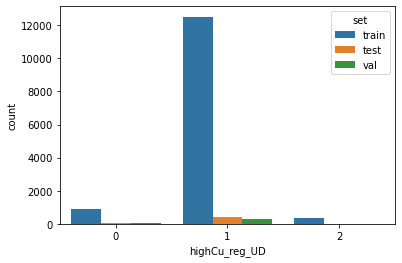

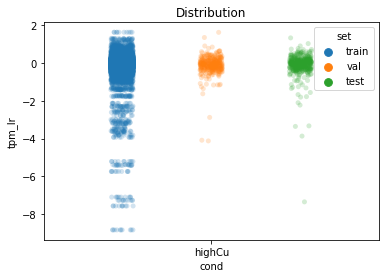

In [28]:
# plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_UD')
# view_train_test_dist(train_df, test_df,["highCu"],val_df=val_df,id_col='locus_tag')

In [31]:
# train_df['highCu_reg_UD'].value_counts()

## Load 5G seqs into data loaders

In [32]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [33]:
# full_train_df,test_df = tu.quick_split(XYdf)
# train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
# dls = tu.build_dataloaders_single(
#     train_df, 
#     val_df, 
#     dataset_types,
#     seq_col='upstream_region',
#     target_col='highCu_reg_UD',
#     sampler=None
# )

dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='posc_seq',
    target_col='posc',
    sampler=None
)


kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

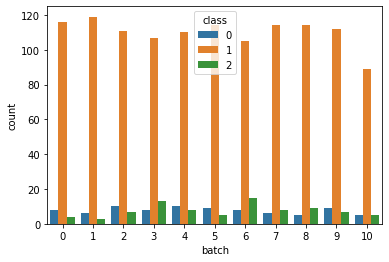

In [34]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [35]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,patience=5000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # create early stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    
    # loops through epochs
    #for epoch in range(epochs): #tqdm?
    with tqdm.trange(epochs) as pbar:
        for i in pbar:
            
    
            train_loss = train_step(model, train_dl, loss_func, opt)
            train_losses.append(train_loss)


            val_loss = val_step(model, val_dl, loss_func)
            #print(epoch, val_loss)
            val_losses.append(val_loss)
            
            pbar.set_description(f"E:{i} | train loss:{train_loss:.3f} | val loss: {val_loss:.3f}")
            
            # copied from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_loss, model,i)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    
    # Epoch and value of best model checkpoint
    estop = early_stopping.best_model_epoch
    best_val_score = early_stopping.val_loss_min 

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    # ^^ Does this need to be returned? I dont' think so... loads in place

    return train_losses, val_losses,estop,best_val_score

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop

    train_losses, test_losses,epoch_stop,best_val_score = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses,epoch_stop,best_val_score

In [36]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [37]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        model.eval()
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        plt.show()

        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

In [38]:
seq_col = 'posc_seq'
#seq_len = len(train_df['upstream_region'].values[0])
seq_len = len(train_df[seq_col].values[0])

In [39]:
seq_len

6

E:4999 | train loss:0.002 | val loss: 0.026: 100%|██████████| 5000/5000 [01:54<00:00, 43.79it/s]


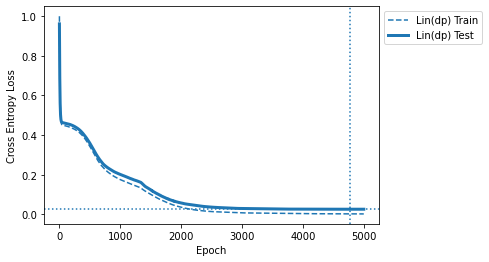

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=24, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [40]:
mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=10, # 100
    h1_size=10, # 100
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label = 'Cross Entropy Loss'
mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d,estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=5000
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)",estop,best_val)]
tu.quick_loss_plot(mer8motif_lin_d_data_label,loss_type=loss_label)

mer8motif_model_lin_d

### CNN model

In [42]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(0.5),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully connected layer 0
#             nn.Linear(fc_node_num0, fc_node_num1),
#             nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num0, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

E:4999 | train loss:0.066 | val loss: 0.000: 100%|██████████| 5000/5000 [02:38<00:00, 31.59it/s]


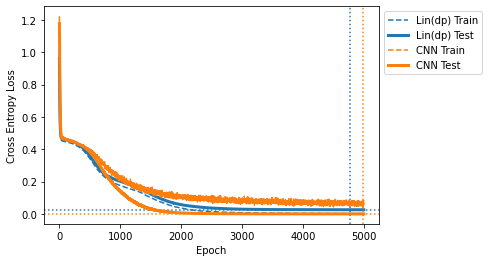

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [43]:
# make model
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=3, #8,
    kernel_size1=3, #8,
    conv_pool_size0=1,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,10.0,10.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"
# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN',estop,best_val)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,loss_type=loss_label)

mer8motif_model_cnn

In [43]:
#tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,sparse_n=20)


Running LinearDeep


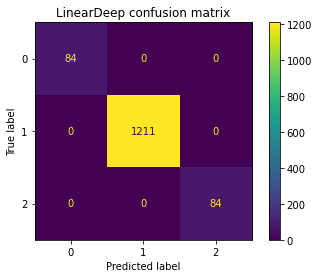

Running CNN


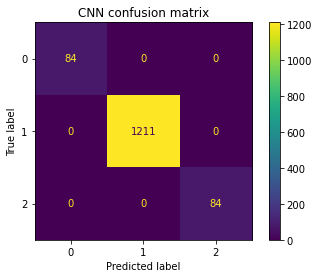

Running LinearDeep


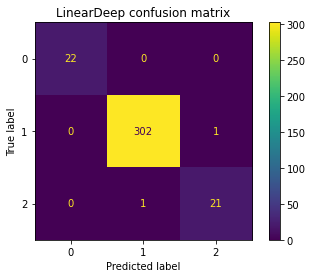

Running CNN


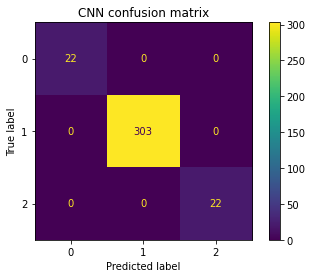

In [46]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
task = "positive control motif"

#oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','highCu_reg_UD']].values])
oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag',class_col]].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [50]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve,matthews_corrcoef

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    mcc = matthews_corrcoef(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f} | mcc={mcc:.3f})")
    for a in ['micro','macro']:#,'weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    mis_classified = []
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            mis_classified.append(gene)
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    return mis_classified
        

In [48]:
lind_res = dfs_val['LinearDeep'][1]
cnn_res = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.994 | mcc=0.975)
micro: p=0.994	 r=0.994	 f1=0.994
macro: p=0.984	 r=0.984	 f1=0.984

CNN (acc=1.000 | mcc=1.000)
micro: p=1.000	 r=1.000	 f1=1.000
macro: p=1.000	 r=1.000	 f1=1.000


# from this I feel pretty sure that my data is indexed correctly!

# filter viz

In [52]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    
#     with tqdm.trange(epochs) as pbar:
#         for i in pbar:
            
    for seq in tqdm.tqdm(seqs):
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


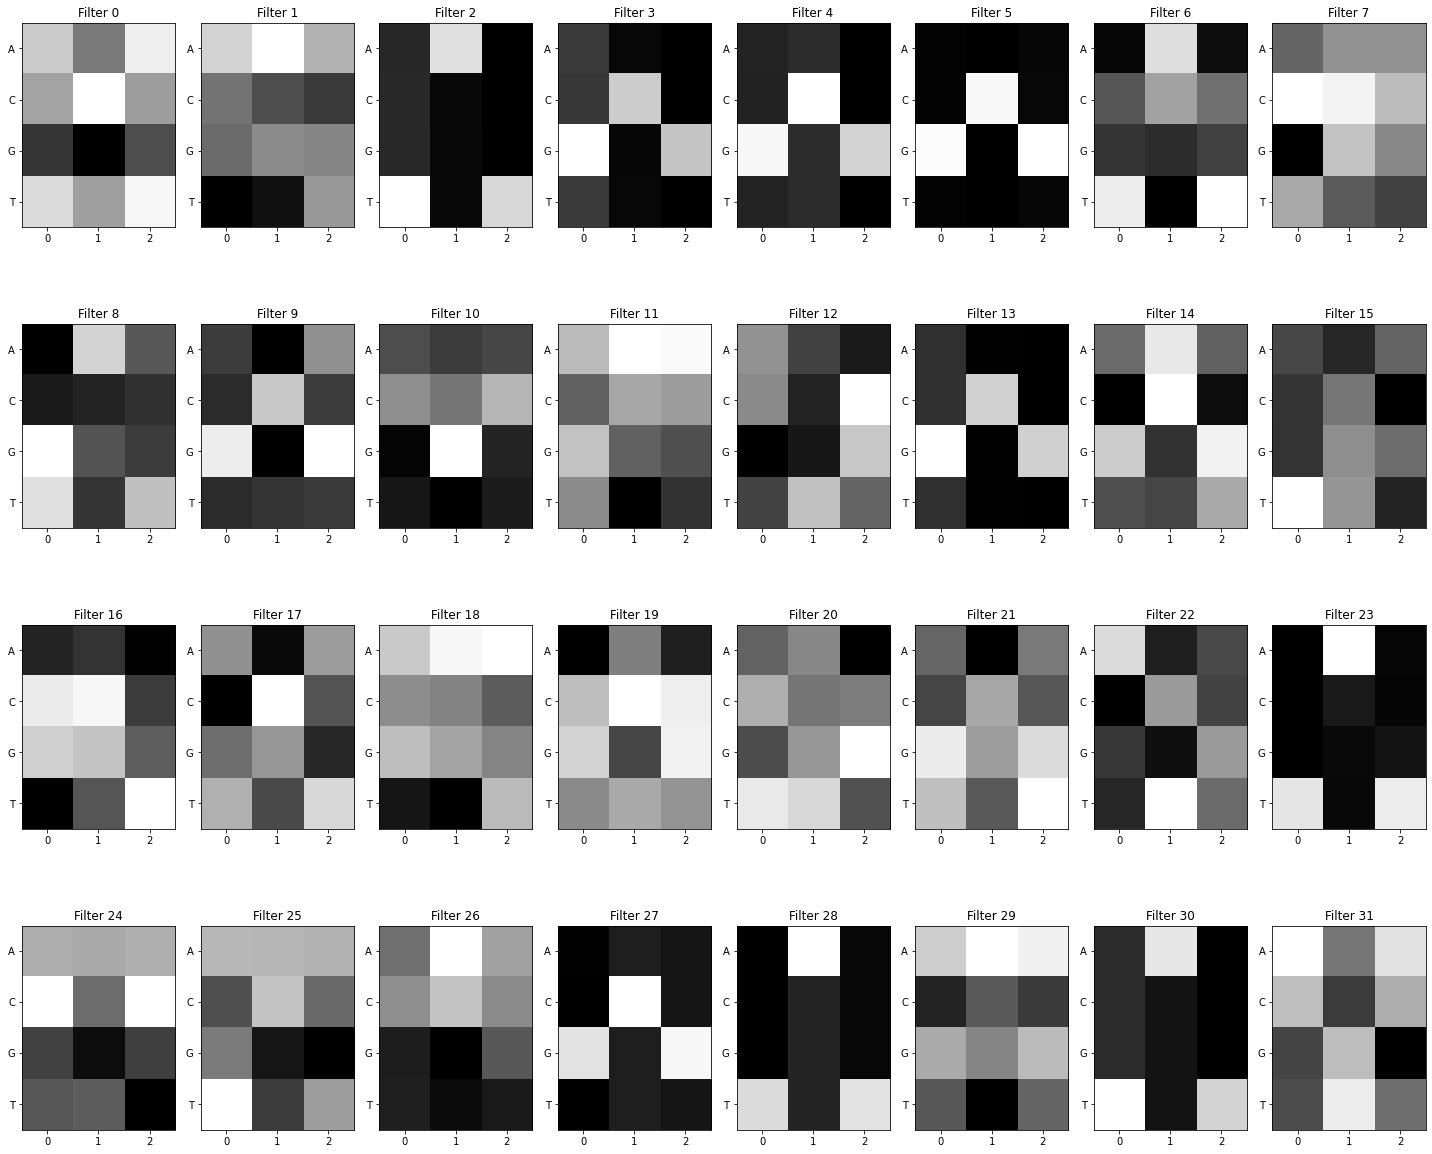

In [54]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [55]:
seqs = [loc2seq[x] for x in train_df['locus_tag'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 32
filt_width 3


100%|██████████| 500/500 [00:02<00:00, 228.12it/s]


torch.Size([32, 4, 3])


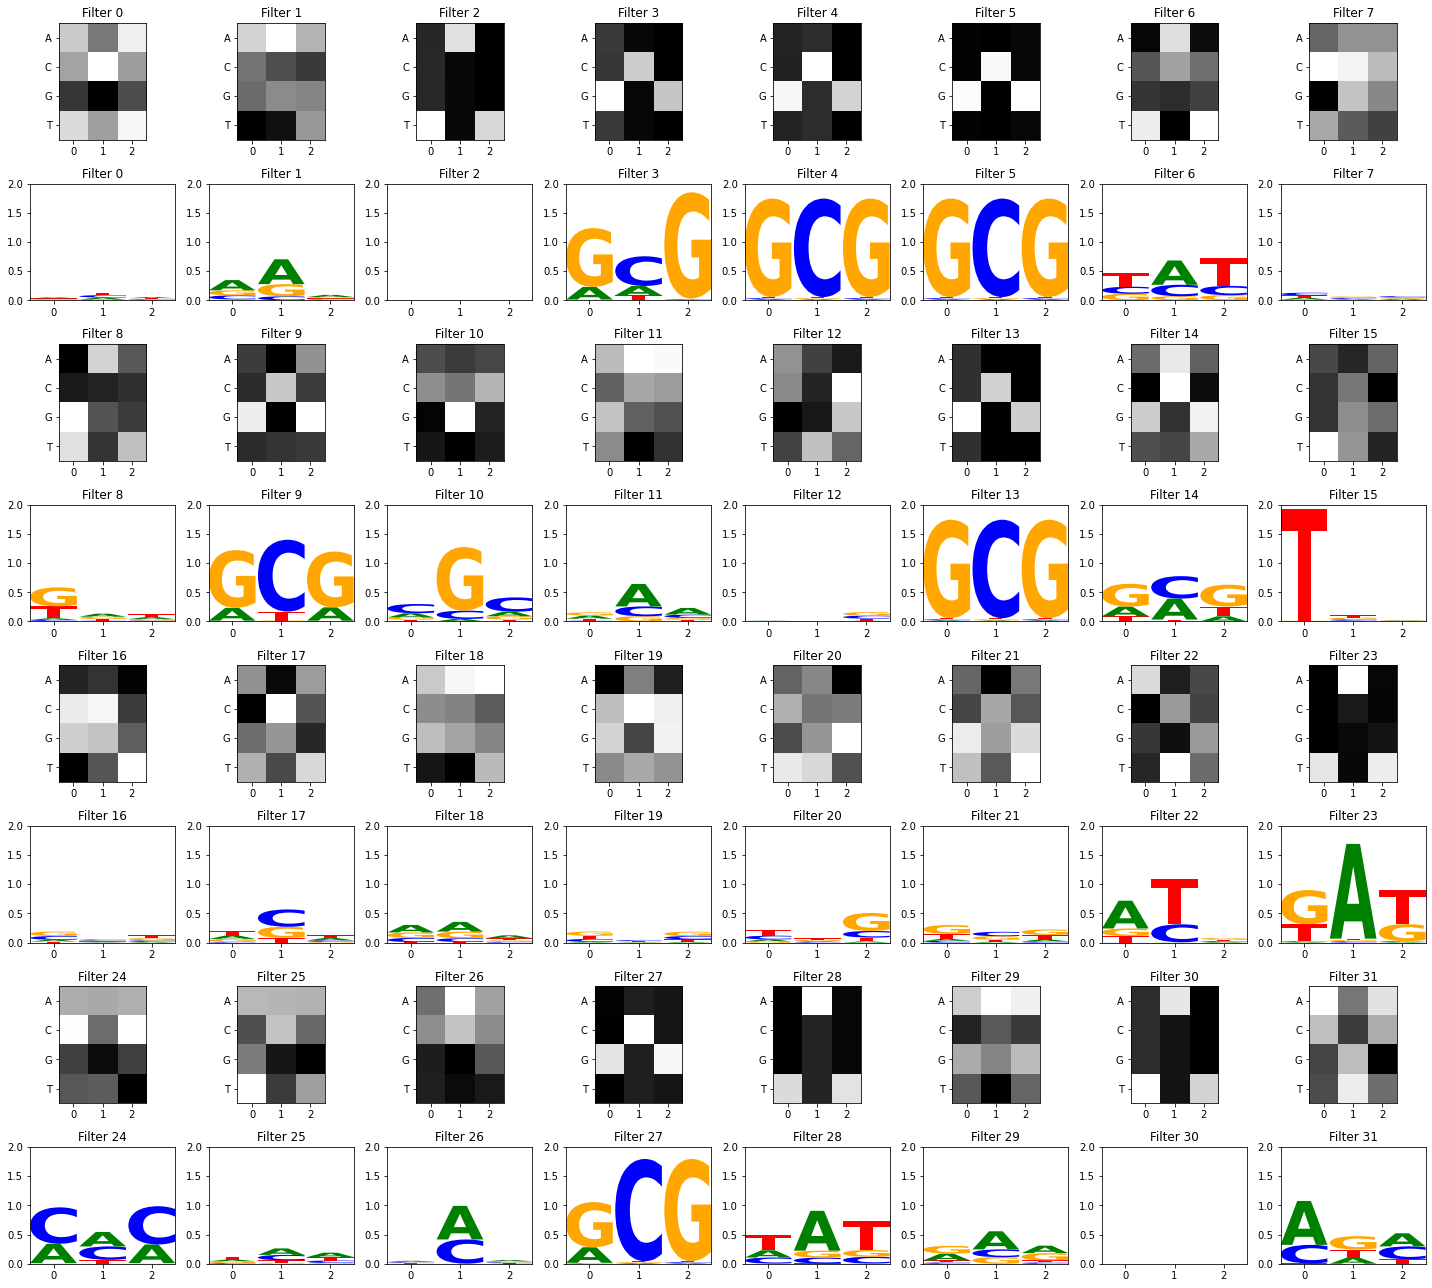

In [57]:
view_filters_and_logos(model_weights,filter_activations,ysc=1)

### some tinkering with KFold CV... maybe come back later

In [50]:
from sklearn.model_selection import StratifiedKFold

In [85]:
cv = StratifiedKFold(5,shuffle=True)

In [115]:
X = np.array(ft)
y = list(np.array(ft['highCu_reg_UD'].values))

trains = []
tests = []
for fold,(train_ids, test_ids) in enumerate(cv.split(X,y)):
    print("fold",fold)
    xtrain = ft.reset_index().iloc[train_ids]
    xtest = ft.reset_index().iloc[test_ids]
    trains.append(xtrain)
    tests.append(xtest)

fold 0
fold 1
fold 2
fold 3
fold 4


In [119]:
for i in range(5):
    traini = trains[i]
    testi = tests[i]
    
    print("fold",i)
    print("TRAIN")
    print(traini['highCu_reg_UD'].value_counts())
    print("TEST")
    print(testi['highCu_reg_UD'].value_counts())
    print()

fold 0
TRAIN
1    1313
0      55
2      12
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     14
2      2
Name: highCu_reg_UD, dtype: int64

fold 1
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 2
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 3
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 4
TRAIN
1    1313
0      56
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     13
2      3
Name: highCu_reg_UD, dtype: int64



## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
